<a href="https://colab.research.google.com/github/EvertonTrentoJR/FittingEIS2orderTF/blob/main/coef_minimization_EIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Second-Order Transfer Function Approach for Fitting Electrical Impedance Spectroscopy Data

**Author:  Everton Trento Jr**

This code implements a curve-fitting algorithm for electrical impedance spectroscopy (EIS) using second-order transfer-function modeling. Two approaches are implemented. The first uses synthetic data as input to the fitting algorithm and can be configured for first- or second-order models. The second uses experimental data acquired with a Keysight E4980A LCR impedance analyzer and a liquid test fixture that measures water as it freezes into ice at −5 °C.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
import os
import pandas as pd
from google.colab import drive

# **Input Synthetic Data**

In [2]:
class InputDataSynthetic:
    def __init__(self, syntP=None, freq=None ):
        self.freq = freq
        self.w = 2 * np.pi * np.asarray(self.freq, dtype=float)
        self.jw = 1j * self.w
        self.syntP = syntP
        self.generateSyntheticTF()
        self.plot_input_data()
        self.magphase_complex = {}

    def get_data(self):
      return self.mag_data, self.phase_data

    def genera1TF(self, params):
        a0, a1, b0, b1 = params
        jw = self.jw
        return (b0 + b1 * jw)/(a0 + a1 * jw)

    def genera2TF(self, params):
        a0, a1, a2, b0, b1, b2 = params
        jw = self.jw
        return  (b0 + b1 * jw + b2 * jw ** 2)/(a0 + a1 * jw + a2 * jw ** 2)

    def generateSyntheticTF(self):
        if len(self.syntP) == 6:
            self.true_params = self.syntP
            self.H_true = self.genera2TF(self.true_params)
        elif len(self.syntP) == 4:
            self.true_params = self.syntP
            self.H_true = self.genera1TF(self.true_params)
        else:
            raise ValueError("syntheticParams must have 4 (1st order) or 6 (2nd order) values")

        self.mag_data = np.abs(self.H_true)
        self.phase_data = np.angle(self.H_true)

    def plot_input_data(self):
        plt.figure(figsize=(12, 5))

        mag_data_db = 20 * np.log10(self.mag_data)

        # Plot magnitude
        plt.subplot(1, 2, 1)
        plt.semilogx(self.freq, mag_data_db, label='Measured Data', color='blue')
        plt.title('Magnitude Response (Input Data)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('|H(jω)| [dB]')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()

        # Plot phase
        plt.subplot(1, 2, 2)
        plt.semilogx(self.freq, self.phase_data, label='Measured Data', color='green')
        plt.title('Phase Response (Input Data)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('∠H(jω) [rad]')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def magphase_to_complex(self):
        self.magphase_complex = self.mag_data * np.exp(1j * self.phase_data)
        return self.magphase_complex


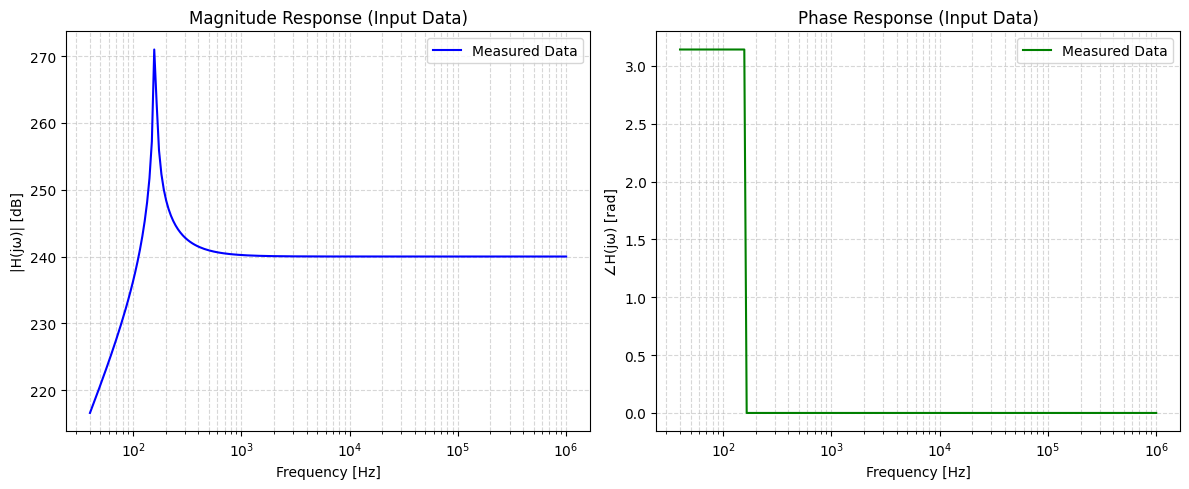

In [3]:
freq = np.logspace(np.log10(40), 6, 201)  # 40 Hz to 1 MHz in 201 points
# syntheticParams = [1.0, 0.0, 1e-6, 10.0] # a0, a1, b0, b1 for first order TF
syntheticParams  = [1.0, 0.0, 1e-6, 0.0, 10.0, 1e6]  # a0, a1, a2, b0, b1, b2 for second order TF
order = 2

input_data_synt = InputDataSynthetic(syntP=syntheticParams, freq=freq)

mag_data, phase_data = input_data_synt.get_data()

magphase_complex = input_data_synt.magphase_to_complex()

# **Input Experimental Data**

In [4]:
class InputDataExperimental:
  def __init__(self, freq=None ):

      self.freq = freq

      self.w = 2 * np.pi * self.freq
      self.jw = 1j * self.w

      self.results = {}
      self.mag_file = {}
      self.mag_data = {}
      self.phase_data = {}
      self.magphase_complex = {}


  def experimental(self):
    drive.mount('/content/drive')
    path = '/content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/'
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

    for file in csv_files:
      full_path = os.path.join(path, file)
      print(f"Reading.... {full_path}")
      df = pd.read_csv(full_path)
      df = df.iloc[:, 1:]
      self.results[file] = df.mean(numeric_only=True)

    self.summary = pd.DataFrame(self.results)
    return self.summary


  def get_data(self):
    self.mag_data.clear()
    self.phase_data.clear()

    for file, vals in self.results.items():
        # ensure even length: pairs (Z, TD) for each frequency
        if vals.size % 2 != 0:
            vals = vals[:-1]
        self.mag_file[file] = vals[0::2]  # Z
        self.phase_data[file] = vals[1::2]  # TD (deg)
        self.mag_data[file] = np.abs(self.mag_file[file]) # Z in dB

    return self.mag_data, self.phase_data

  def magphase_to_complex(self):
    self.magphase_complex.clear()
    for file in self.mag_data.keys():
      self.magphase_complex[file] = np.asarray(self.mag_data[file]) * np.exp(1j * np.asarray(self.phase_data[file]) * np.pi/180) # Convert phase to radians
    return self.magphase_complex

  def plot_input_data(self):

    files = sorted(set(self.mag_data) & set(self.phase_data))

    for file in files:
      print("Plot experimental data:  ")

      plt.figure(figsize=(12, 5))
      plt.suptitle(f'Experimental Data: {file}')

      # Magnitude
      plt.subplot(1, 2, 1)
      plt.semilogx(self.freq, 20 * np.log10(self.mag_data[file]), label=f'{file}', marker='o')
      plt.title('Magnitude Response (Input Data)')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('|H(jω)| [dB]')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()

      # Phase
      plt.subplot(1, 2, 2)
      plt.semilogx(self.freq, self.phase_data[file], label=f'{file}', marker='x')
      plt.title('Phase Response (Input Data)')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('∠H(jω) [deg]')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()

      plt.tight_layout()
      plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading.... /content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/W.csv
Reading.... /content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/C0.csv
Reading.... /content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/ICE.csv
Plot experimental data:  


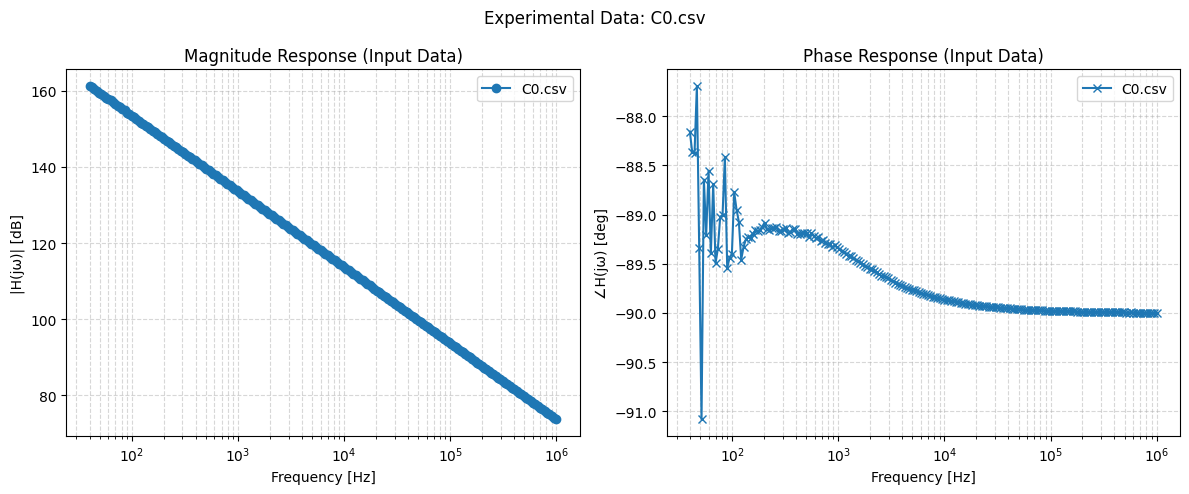

Plot experimental data:  


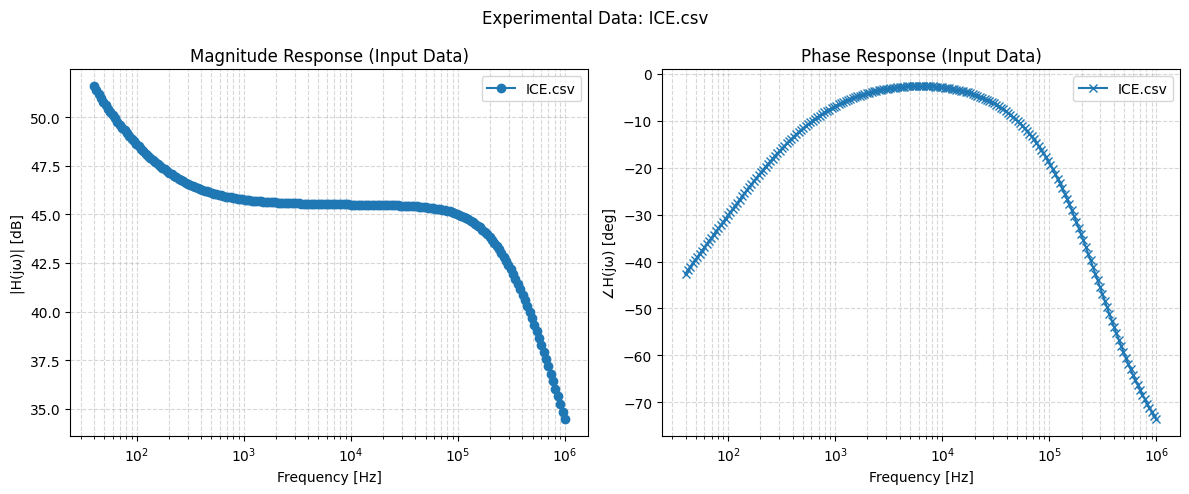

Plot experimental data:  


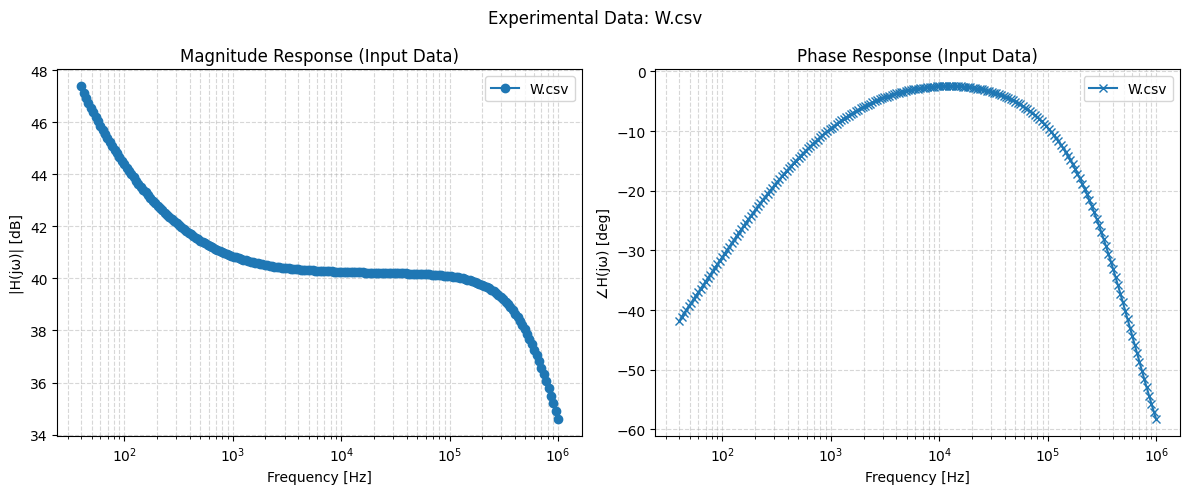

In [5]:
freq = np.logspace(np.log10(40), 6, 201)  # 40 Hz to 1 MHz in 201 points

input_exp = InputDataExperimental(freq=freq)

summary = input_exp.experimental()

mag_exp, phase_exp = input_exp.get_data()

input_exp.plot_input_data()

magphase_complex_exp = input_exp.magphase_to_complex()

# **Define Loss Function**

In [6]:
def loss_function_complex(params, freq, magphase_complex, order=2):

    w = 2 * np.pi * np.asarray(freq, dtype=float)
    jw = 1j * w

    if order == 2:
        a0, a1, a2, b0, b1, b2  = params
        num = b0 + b1 * jw + b2 * (jw**2)
        den = a0 + a1 * jw + a2 * (jw**2)
        H = num / den
    else:
        a0, a1, b0, b1 = params
        H = (b0 + b1 * jw)/(a0 + a1 * jw)

    # Compare complex values in linear units
    diff = H - np.asarray(magphase_complex)

    # Sum of squared error as a scalar
    return float(np.vdot(diff, diff).real)
    # np.vdot - If the first argument is complex the complex conjugate of the first argument is used for the calculation of the dot product.

In [18]:
a2_span = np.arange(-1e7, 1e7, 10000)
print(len(a2_span))

2000


**testing loss function**


In [40]:
a0 = 1.0
a1 = 0.0
a2 = 1e-6
b0 = 0.0
b1 = 10.0
b2 = 1e6

params = [a0, a1, a2, b0, b1, b2]
loss = loss_function_complex(params, freq, magphase_complex, order=2)
print("Loss function for the synthetic data:", loss)

# param A0
a0_span = np.arange(-4, 4.1, 0.1)
losses_a0 = []
for val in a0_span:
    test_params = [val, a1, a2, b0, b1, b2]
    loss_a0 = loss_function_complex(test_params, freq, magphase_complex, order=2)
    losses_a0.append(loss_a0)

# param A1
a1_span = np.arange(-1, 1.1, 0.1)
losses_a1 = []
for val in a1_span:
    test_params = [a0, val, a2, b0, b1, b2]
    loss_a1 = loss_function_complex(test_params, freq, magphase_complex, order=2)
    losses_a1.append(loss_a1)

# param A2
a2_span = np.arange(-1e7, 1e7, 10000)
losses_a2 = []
for val in a2_span:
    test_params = [a0, a1, val, b0, b1, b2]
    loss_a2 = loss_function_complex(test_params, freq, magphase_complex, order=2)
    losses_a2.append(loss_a2)

# param B0
b0_span = np.arange(-1, 1.1, 0.1)
losses_b0 = []

for val in b0_span:
    test_params = [a0, a1, a2, val, b1, b2]
    loss_b0 = loss_function_complex(test_params, freq, magphase_complex, order=2)
    losses_b0.append(loss_b0)

# param B1
b1_span = np.arange(-20, 40.1,0.1)
losses_b1 = []

for val in b1_span:
    test_params = [a0, a1, a2, b0, val, b2]
    loss_b1 = loss_function_complex(test_params, freq, magphase_complex, order=2)
    losses_b1.append(loss_b1)

# param B2
b2_span = np.arange(-1e7, 1e7, 10000)
losses_b2 = []

for val in b2_span:
    test_params = [a0, a1, a2, b0, b1, val]
    loss_b2 = loss_function_complex(test_params, freq, magphase_complex, order=2)
    losses_b2.append(loss_b2)

Loss function for the synthetic data: 1.6380228418662815e-05


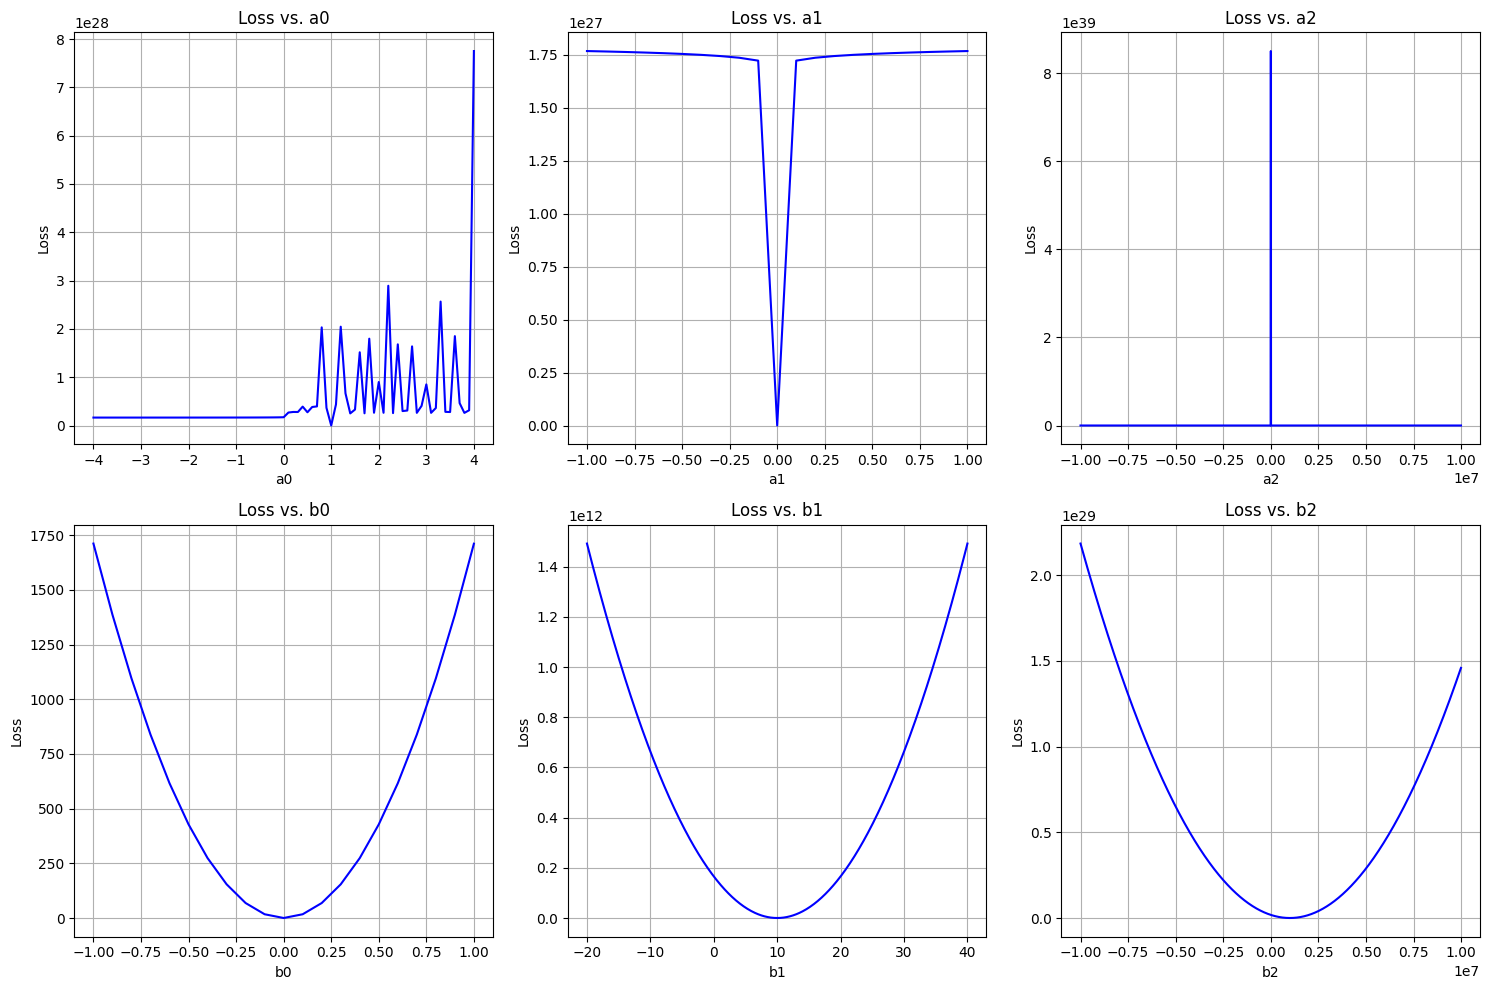

In [41]:
fig, axex = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axex.flatten()

ax1.plot(a0_span, losses_a0, 'b-')
ax1.set_title('Loss vs. a0')
ax1.set_xlabel('a0')
ax1.set_ylabel('Loss')
ax1.grid()

ax2.plot(a1_span, losses_a1, 'b-')
ax2.set_title('Loss vs. a1')
ax2.set_xlabel('a1')
ax2.set_ylabel('Loss')
ax2.grid()

ax3.plot(a2_span, losses_a2, 'b-')
ax3.set_title('Loss vs. a2')
ax3.set_xlabel('a2')
ax3.set_ylabel('Loss')
ax3.grid()

ax4.plot(b0_span, losses_b0, 'b-')
ax4.set_title('Loss vs. b0')
ax4.set_xlabel('b0')
ax4.set_ylabel('Loss')
ax4.grid()

ax5.plot(b1_span, losses_b1, 'b-')
ax5.set_title('Loss vs. b1')
ax5.set_xlabel('b1')
ax5.set_ylabel('Loss')
ax5.grid()

ax6.plot(b2_span, losses_b2, 'b-')
ax6.set_title('Loss vs. b2')
ax6.set_xlabel('b2')
ax6.set_ylabel('Loss')
ax6.grid()

plt.tight_layout()
plt.show()


# **Fitted coef2spectrum function**

In [34]:
def coef2spectrum(fitparams,freq,order=2,):
  # applies the fit coeficients and calculate the fitted phase and magnitude
  w = 2 * np.pi * np.asarray(freq, dtype=float)
  jw = 1j * w

  if order == 2:
        a0, a1, a2, b0, b1, b2  = fitparams
        num = b0 + b1 * jw + b2 * jw**2
        den = a0 + a1 * jw + a2 * jw**2
        H_fit = num / den
  else:
      a0, a1, b0, b1 = fitparams
      H_fit = (b0 + b1 * jw)/ (a0 + a1 * jw)

  mag_fit = np.abs(H_fit)
  phase_fit = np.angle(H_fit)

  return mag_fit, phase_fit

def pltFit(freq, mag_data, mag_fit, phase_data, phase_fit):

  mag_data = 20 * np.log10(mag_data)
  mag_fit = 20 * np.log10(mag_fit)

  # plot Magnitude and Phase for fitted and raw data
  plt.figure(figsize=(12, 5))

  # Plot magnitude
  plt.subplot(1, 2, 1)
  plt.semilogx(freq, mag_data, label='Measured Data', color='blue')
  plt.semilogx(freq, mag_fit, label='Measured Data', color='red',linestyle=':')
  plt.title('Magnitude Response (Input Data)')
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('|H(jω)| [dB]')
  plt.grid(True, which='both', linestyle='--', alpha=0.5)
  plt.legend()

  # Plot phase
  plt.subplot(1, 2, 2)
  plt.semilogx(freq, phase_data, label='Measured Data', color='green')
  plt.semilogx(freq, phase_fit, label='Measured Data', color='red',linestyle=':')
  plt.title('Phase Response (Input Data)')
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('∠H(jω) [rad]')
  plt.grid(True, which='both', linestyle='--', alpha=0.5)
  plt.legend()

  plt.tight_layout()
  plt.show()

# **MINIMIZE METHOD**

Synthetic data

Optimization terminated successfully.
         Current function value: 98914.773930
         Iterations: 656
         Function evaluations: 1248
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 98914.77393040866
             x: [ 1.001e+00  5.360e-19  1.001e-06 -2.586e+01  1.001e+01
                  1.001e+06]
           nit: 656
          nfev: 1248
 final_simplex: (array([[ 1.001e+00,  5.360e-19, ...,  1.001e+01,
                         1.001e+06],
                       [ 1.001e+00,  5.360e-19, ...,  1.001e+01,
                         1.001e+06],
                       ...,
                       [ 1.001e+00,  5.360e-19, ...,  1.001e+01,
                         1.001e+06],
                       [ 1.001e+00,  5.360e-19, ...,  1.001e+01,
                         1.001e+06]]), array([ 9.891e+04,  9.891e+04,  9.891e+04,  9.891e+04,
                        9.891e+04,  9.891e+04,  9.891e+04]))


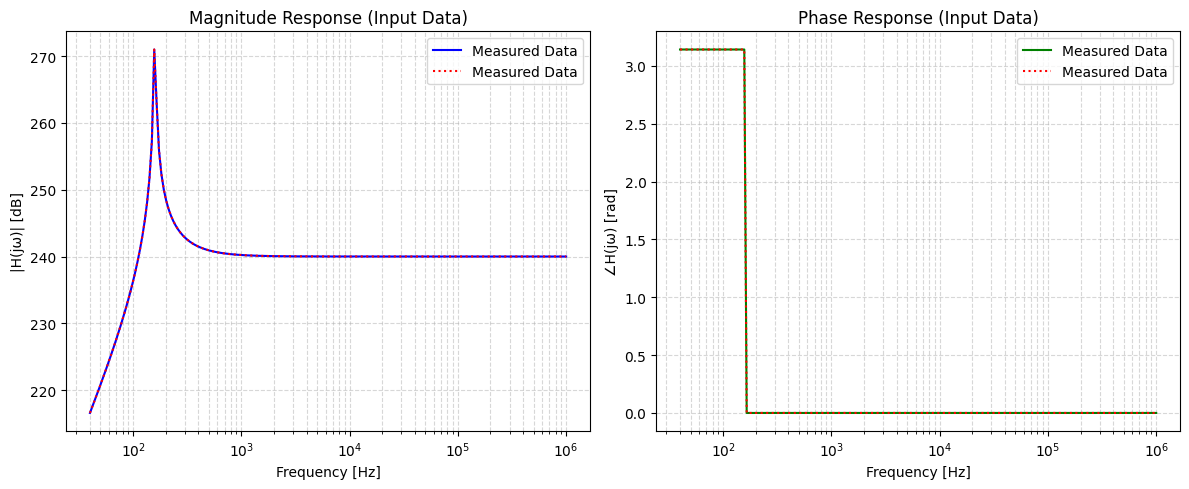

In [36]:
initial_guess = [1.0, 0.0, 1e-6, 0.0, 0.0, 1e6]   # a1, a2, b0, b1, b2 for second order TF

result = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex, order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result)

optimized_params_synt1 = result.x
mag_fit_synt1, phase_fit_synt1 = coef2spectrum(optimized_params_synt1,freq,order=order)
pltFit(freq, mag_data, mag_fit_synt1, phase_data, phase_fit_synt1)

Experimental data

**C0 - Air**

Optimization terminated successfully.
         Current function value: 122003103544363840.000000
         Iterations: 964
         Function evaluations: 1771
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.2200310354436384e+17
             x: [ 2.349e-01  1.743e-04  2.764e-06  2.686e-03  3.805e-03
                 -2.114e+01]
           nit: 964
          nfev: 1771
 final_simplex: (array([[ 2.349e-01,  1.743e-04, ...,  3.805e-03,
                        -2.114e+01],
                       [ 2.349e-01,  1.743e-04, ...,  3.805e-03,
                        -2.114e+01],
                       ...,
                       [ 2.349e-01,  1.743e-04, ...,  3.805e-03,
                        -2.114e+01],
                       [ 2.349e-01,  1.743e-04, ...,  3.805e-03,
                        -2.114e+01]]), array([ 1.220e+17,  1.220e+17,  1.220e+17,  1.220e+17,
                        1.220e+17,  1.220e+17,  1.220e+17]))


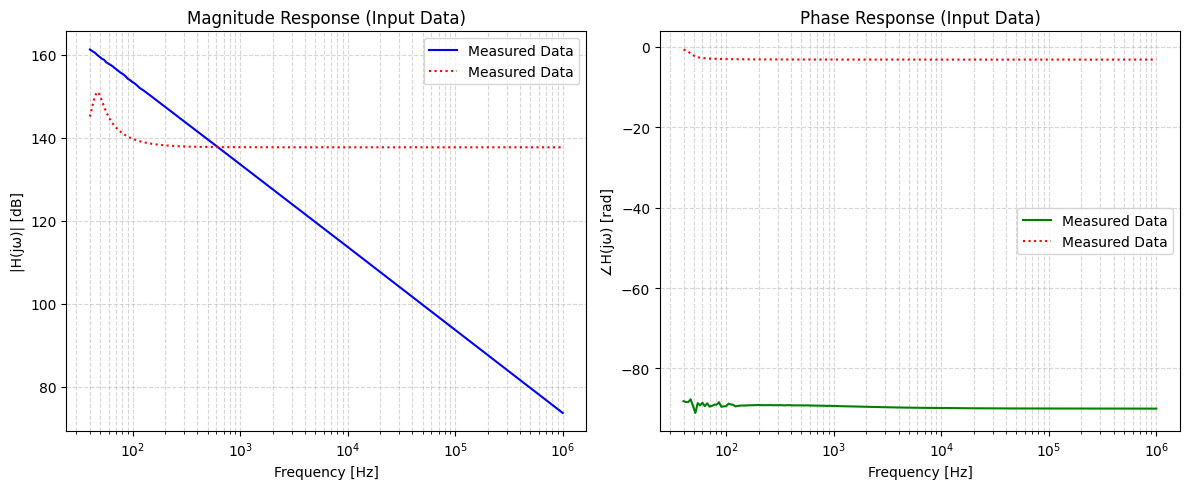

In [37]:
result_exp_C0 = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex_exp['C0.csv'], order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_C0)
optimized_params_exp_C0 = result_exp_C0.x

mag_fit_exp_C0, phase_fit_exp_C0 = coef2spectrum(optimized_params_exp_C0,freq,order=order)
pltFit(freq, mag_exp['C0.csv'], mag_fit_exp_C0, phase_exp['C0.csv'], phase_fit_exp_C0)

**WATER**

Optimization terminated successfully.
         Current function value: 1648752.559514
         Iterations: 316
         Function evaluations: 577
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1648752.559513518
             x: [ 1.196e-01  6.539e-03  2.174e-06 -1.073e-03  1.956e-03
                  1.915e-04]
           nit: 316
          nfev: 577
 final_simplex: (array([[ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         1.915e-04],
                       [ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         1.915e-04],
                       ...,
                       [ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         1.915e-04],
                       [ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         1.915e-04]]), array([ 1.649e+06,  1.649e+06,  1.649e+06,  1.649e+06,
                        1.649e+06,  1.649e+06,  1.649e+06]))


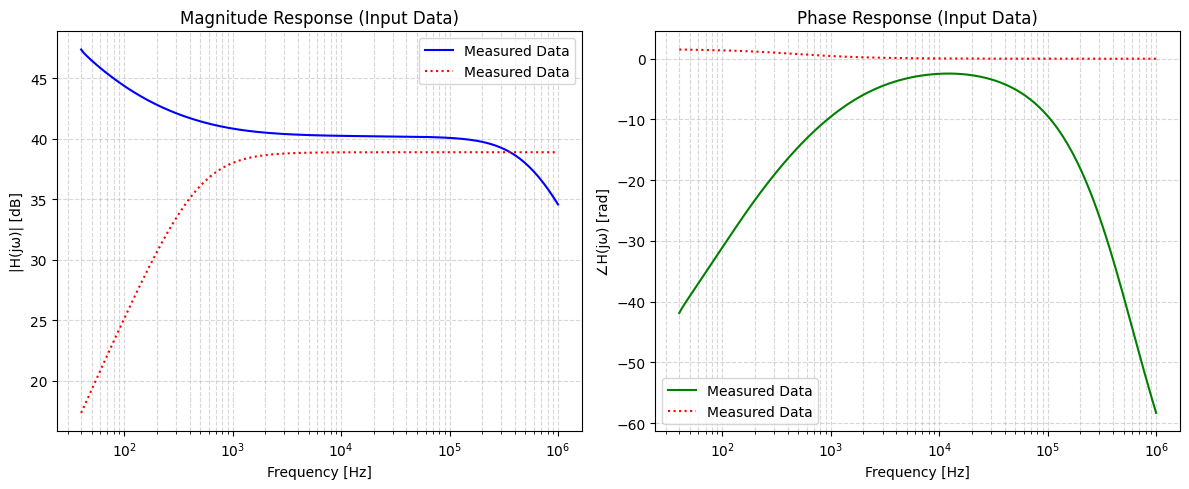

In [38]:
result_exp_W = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex_exp['W.csv'], order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_W)
optimized_params_exp_W = result_exp_W.x

mag_fit_exp_W, phase_fit_exp_W = coef2spectrum(optimized_params_exp_W,freq,order=order)
pltFit(freq, mag_exp['W.csv'], mag_fit_exp_W, phase_exp['W.csv'], phase_fit_exp_W)

**ICE**

Optimization terminated successfully.
         Current function value: 4801578.289799
         Iterations: 314
         Function evaluations: 572
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4801578.289798541
             x: [ 1.196e-01  6.539e-03  2.174e-06 -1.073e-03  1.956e-03
                  3.191e-04]
           nit: 314
          nfev: 572
 final_simplex: (array([[ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         3.191e-04],
                       [ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         3.191e-04],
                       ...,
                       [ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         3.191e-04],
                       [ 1.196e-01,  6.539e-03, ...,  1.956e-03,
                         3.191e-04]]), array([ 4.802e+06,  4.802e+06,  4.802e+06,  4.802e+06,
                        4.802e+06,  4.802e+06,  4.802e+06]))


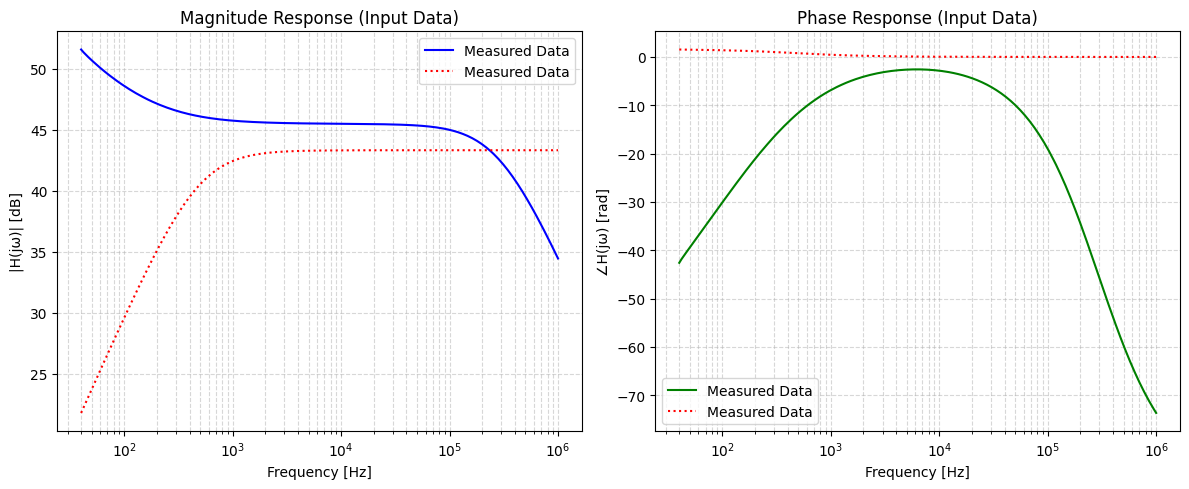

In [39]:
result_exp_ICE = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex_exp['ICE.csv'], order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_ICE)
optimized_params_exp_ICE = result_exp_ICE.x

mag_fit_exp_ICE, phase_fit_exp_ICE = coef2spectrum(optimized_params_exp_ICE,freq,order=order)
pltFit(freq, mag_exp['ICE.csv'], mag_fit_exp_ICE, phase_exp['ICE.csv'], phase_fit_exp_ICE)

# **References**



1.   https://joss.theoj.org/papers/10.21105/joss.02349.pdf
2.   https://impedancepy.readthedocs.io/en/latest/getting-started.html

scipy.minimize
https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html#optimize-minimize-newtoncg